In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

Using TensorFlow backend.


<a id="data"></a>
## 1. Data preparation and processing


<a id="preparation"></a>
### Data preparation


In [2]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("/kaggle/input/audio-paths/Data_path.csv")
ref.head()

,labels,source,path
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [3]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

7692


,feature
0,"[-25.742002, -26.182264, -25.468557, -25.19893..."
1,"[-41.184326, -38.827896, -39.00878, -41.509396..."
2,"[-25.528027, -23.866304, -22.509321, -22.32029..."
3,"[-16.746674, -18.525646, -22.26418, -22.016502..."
4,"[-25.793976, -25.637814, -25.623514, -24.90813..."


<a id="processing"></a>
### Data processing

In [4]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.742002,-26.182264,-25.468557,-25.198936,-25.429790,-23.347939,-16.800249,...,-3.119451,-4.260779,-5.274271,-5.775263,-7.272358,-7.340224,-7.019254,-8.643790,-15.420984,-19.470566
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-41.184326,-38.827896,-39.008781,-41.509396,-39.770164,-34.743958,-30.551401,...,-27.156342,-25.647068,-25.140005,-26.746456,-27.039560,-27.250130,-26.599070,-25.778673,-24.685337,-25.448017
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.528027,-23.866304,-22.509321,-22.320293,-17.513348,-12.073632,-9.537952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-16.746674,-18.525646,-22.264179,-22.016502,-23.868864,-23.068270,-23.807617,...,-27.922167,-27.525471,-27.459106,-26.916111,-27.472073,-29.056606,-28.666271,-28.376913,-24.786333,-21.834438
4,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.793976,-25.637814,-25.623514,-24.908131,-24.204031,-23.441559,-22.504555,...,-8.755323,-8.886434,-10.918306,-11.311976,-10.998631,-9.800958,-9.060637,-9.556485,-3.739459,3.027150


In [5]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(7692, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.742002,-26.182264,-25.468557,-25.198936,-25.429790,-23.347939,-16.800249,...,-3.119451,-4.260779,-5.274271,-5.775263,-7.272358,-7.340224,-7.019254,-8.643790,-15.420984,-19.470566
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-41.184326,-38.827896,-39.008781,-41.509396,-39.770164,-34.743958,-30.551401,...,-27.156342,-25.647068,-25.140005,-26.746456,-27.039560,-27.250130,-26.599070,-25.778673,-24.685337,-25.448017
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.528027,-23.866304,-22.509321,-22.320293,-17.513348,-12.073632,-9.537952,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-16.746674,-18.525646,-22.264179,-22.016502,-23.868864,-23.068270,-23.807617,...,-27.922167,-27.525471,-27.459106,-26.916111,-27.472073,-29.056606,-28.666271,-28.376913,-24.786333,-21.834438
4,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.793976,-25.637814,-25.623514,-24.908131,-24.204031,-23.441559,-22.504555,...,-8.755323,-8.886434,-10.918306,-11.311976,-10.998631,-9.800958,-9.060637,-9.556485,-3.739459,3.027150


In [6]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3966,-21.066866,-18.238337,-18.433176,-16.315235,-17.865822,-18.237429,-17.489285,-15.349671,-16.453423,-17.910446,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3755,-18.819370,-18.412889,-19.619820,-18.183479,-17.329638,-19.325487,-20.616140,-20.815889,-19.769535,-20.781431,...,-17.777790,-20.541279,-23.203836,-22.139683,-20.988783,-21.126905,-20.438921,-21.601082,-23.239523,-25.989872
2908,-14.494086,-14.097105,-14.332422,-13.951591,-14.454960,-15.945662,-15.823812,-15.345850,-13.973478,-13.672979,...,-17.157310,-15.842101,-17.993641,-18.876499,-16.210676,-16.170071,-17.360296,-16.517529,-15.055435,-16.842154
2412,-4.328098,-8.390893,-25.962193,-25.611288,-26.380314,-26.592659,-26.998405,-26.514259,-25.160261,-25.629143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7457,-19.783806,-19.927948,-20.274172,-18.550488,-18.581591,-17.085333,-13.907487,-13.577923,-13.186737,-11.550720,...,-19.027824,-17.259869,-16.888546,-18.512501,-19.119020,-18.877819,-18.005552,-20.243580,-20.669796,-19.728006
6116,-15.687602,-14.142726,-14.975580,-15.931285,-15.217874,-14.604826,-15.403960,-18.364264,-19.986132,-18.074091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5123,-20.018839,-18.896009,-17.593672,-17.304655,-15.754000,-13.897630,-13.983196,-14.520553,-13.806339,-15.886168,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5221,-13.118306,-12.208470,-11.396108,-12.528118,-13.194167,-14.307224,-13.312699,-12.387478,-11.655973,-12.210997,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2303,-13.478893,-17.289843,-29.484005,-27.146614,-22.446583,-17.996101,-19.088993,-21.493195,-22.346474,-23.249737,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4812,-23.372372,-21.210613,-18.222404,-17.096304,-17.546446,-19.712996,-14.258968,-11.686646,-10.546225,-10.214508,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3966,-0.118277,0.150891,0.341825,0.509690,0.370582,0.335043,0.390912,0.563923,0.465564,0.341910,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317
3755,0.057085,0.136592,0.242839,0.353823,0.415186,0.244666,0.131899,0.111958,0.191446,0.104419,...,-0.705245,-0.906626,-1.083426,-1.003414,-0.941522,-0.946425,-0.891783,-0.986019,-1.110519,-1.291204
2908,0.394567,0.490126,0.683893,0.706888,0.654322,0.525402,0.528872,0.564239,0.670563,0.692437,...,-0.662970,-0.586893,-0.730109,-0.783231,-0.619014,-0.612776,-0.685616,-0.645409,-0.559034,-0.678237
2412,1.187774,0.957560,-0.286216,-0.265876,-0.337714,-0.358960,-0.396777,-0.359201,-0.254165,-0.296588,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317
7457,-0.018166,0.012484,0.188256,0.323204,0.311040,0.430738,0.687611,0.710417,0.735597,0.867992,...,-0.790415,-0.683358,-0.655170,-0.758670,-0.815319,-0.795037,-0.728827,-0.895063,-0.937358,-0.871611
6116,0.301443,0.486389,0.630243,0.541723,0.590858,0.636774,0.563651,0.314667,0.173541,0.328373,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317
5123,-0.036504,0.097017,0.411853,0.427143,0.546259,0.695515,0.681340,0.632477,0.684379,0.509360,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317
5221,0.501913,0.644837,0.928829,0.825648,0.759204,0.661494,0.736880,0.808846,0.862133,0.813373,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317
2303,0.473778,0.228588,-0.579992,-0.393967,-0.010478,0.355088,0.258400,0.055956,-0.021571,-0.099761,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317
4812,-0.298165,-0.092588,0.359406,0.444526,0.397150,0.212479,0.658496,0.866794,0.953868,0.978524,...,0.506022,0.491009,0.490087,0.490459,0.475161,0.475645,0.476954,0.461305,0.455477,0.450317


In [8]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(5769, 216)
['female_angry' 'female_fear' 'female_happy' 'female_sad' 'male_angry'
 'male_fear' 'male_happy' 'male_sad']


In [9]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(5769, 216, 1)

<a id="modelling"></a>
## 2. Modelling 

In [10]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 256)           0         
__________

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Train on 5769 samples, validate on 1923 samples
Epoch 1/50
5769/5769 [==============================] - 14s 2ms/step - loss: 1.8558 - acc: 0.2871 - val_loss: 1.7832 - val_acc: 0.3599
Epoch 2/50
5769/5769 [==============================] - 5s 797us/step - loss: 1.6765 - acc: 0.3531 - val_loss: 1.7064 - val_acc: 0.3812
Epoch 3/50
5769/5769 [==============================] - 4s 735us/step - loss: 1.5965 - acc: 0.3917 - val_loss: 1.6458 - val_acc: 0.4087
Epoch 4/50
5769/5769 [==============================] - 4s 720us/step - loss: 1.5419 - acc: 0.4143 - val_loss: 1.5981 - val_acc: 0.4077
Epoch 5/50
5769/5769 [==============================] - 4s 727us/step - loss: 1.5072 - acc: 0.4243 - val_loss: 1.5734 - val_acc: 0.4347
Epoch 6/50
5769/5769 [==============================] - 4s 721us/step - loss: 1.4782 - acc: 0.4406 - val_loss: 1.5336 - val_acc: 0.4368
Epoch 7/50
5769/5769 [==============================] - 4s 720us/step - loss: 1.4478 - acc: 0.4467 - val_loss: 1.5134 - val_acc: 0.4431
E

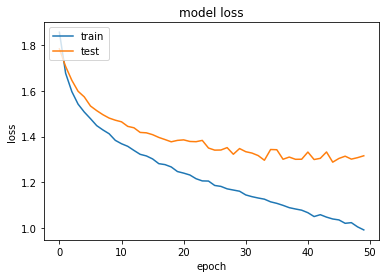

In [12]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

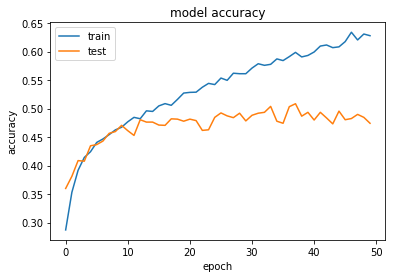

In [13]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<a id="serialise"></a>
## 3. Model serialisation

In [14]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/Emotion_Model.h5 


<a id="validation"></a>
## 4. Model validation

In [15]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 47.43%


In [16]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

1923/1923 [==============================] - 1s 284us/step


array([2, 1, 0, ..., 0, 4, 0])

In [17]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_happy,female_happy
171,female_happy,female_happy
172,female_sad,female_sad
173,female_happy,female_fear
174,female_happy,female_angry
175,male_happy,female_angry
176,female_happy,female_happy
177,female_happy,female_fear
178,male_angry,male_angry
179,female_angry,male_fear


In [18]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,452
female_fear,281
female_happy,367
female_sad,310
male_angry,157
male_fear,141
male_happy,113
male_sad,102


In [19]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


#### Emotion by gender accuracy  

0.47425897035881437


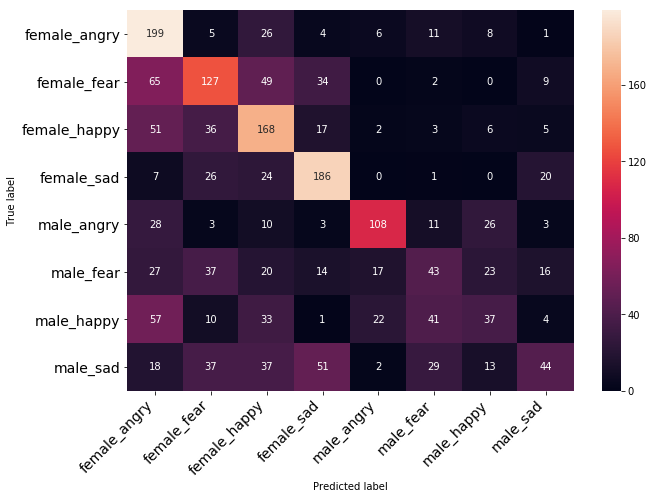

In [20]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.5694227769110765


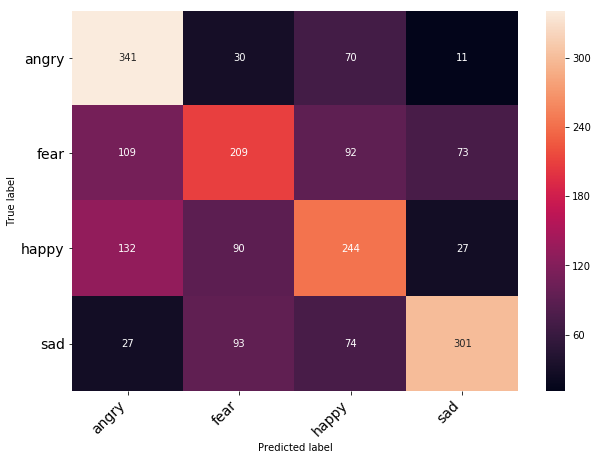

In [21]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [22]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.56      0.75      0.64       452
        fear       0.50      0.43      0.46       483
       happy       0.51      0.49      0.50       493
         sad       0.73      0.61      0.66       495

    accuracy                           0.57      1923
   macro avg       0.57      0.57      0.57      1923
weighted avg       0.57      0.57      0.57      1923



In [23]:
# Importing required libraries 
from keras.models import Sequential, Model, model_from_json
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import warnings
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [24]:
data, sampling_rate = librosa.load('/kaggle/input/recording2/happy.wav')
ipd.Audio('/kaggle/input/recording2/happy.wav')

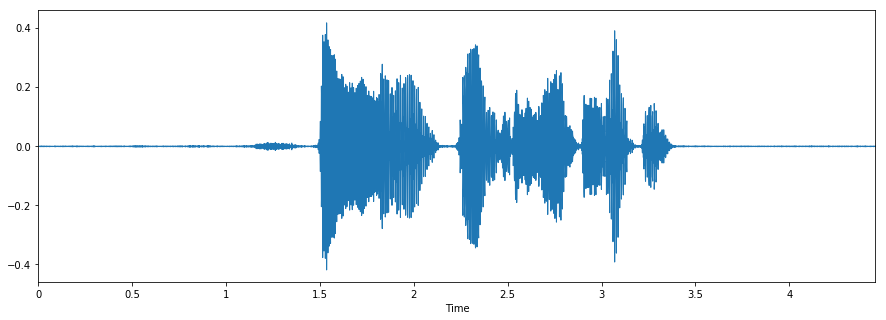

In [25]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [26]:
# loading json and model architecture 
json_file = open('/kaggle/working/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/kaggle/working/saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


In [27]:
# Lets transform the dataset so we can apply the predictions
path = '/kaggle/input/recording2/sad.wav'
X, sample_rate = librosa.load( path
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-31.018749,-30.029652,-31.251566,-30.849602,-30.251213,-31.364716,-32.784237,-32.896366,-33.444698,-32.653912,...,-10.011315,-11.853395,-13.384491,-11.053873,-10.837304,-11.346298,-12.429474,-12.839601,-13.06424,-13.584594


In [28]:
# Apply predictions
newdf= np.expand_dims(newdf, axis=2)
newpred = loaded_model.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

newpred

1/1 [==============================] - 0s 476ms/step


array([[2.4610209e-09, 7.8056523e-13, 1.1842312e-07, 1.7218358e-03,
        3.1792172e-07, 4.7367535e-04, 6.1936017e-02, 9.3586791e-01]],
      dtype=float32)

In [29]:
filename = '/kaggle/working/labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final[0].split("_")[1]) #emo(final) #gender(final)

sad
